<a href="https://colab.research.google.com/github/skintl/ship-classification-with-transfer-learning/blob/main/ship_classification_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
import os
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Loading and Understanding the Data

In [2]:
import pandas as pd

train_df=pd.read_csv("/content/train.csv") # change path
train_df.head()

image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2

In [ ]:
train_df.shape

So our train data consists of images of ships, with 5 different classes -
1.          Cargo
1.          Military
1.          Carrier
1.          Cruise
1.          Tankers
    
    
We have 6252 such images of all these classes and we will try to build a neural network (Specifically a Convolutional Neural Network) to predict the type of ship given an image for the same.

In [ ]:
dictclass = {1: 'Cargo',
2: 'Military',
3: 'Carrier',
4: 'Cruise',
5: 'Tankers'}

<Axes: xlabel='category', ylabel='count'>

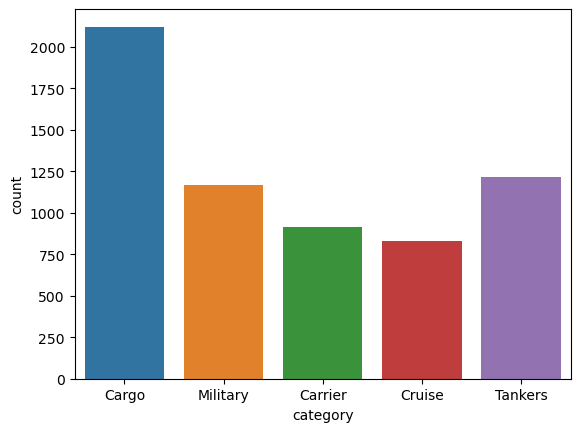

In [ ]:
sns.countplot(x=train_df["category"].map(dictclass))

It seems that the images of cargo ships are quite higher than all the other classes

# Pre Processing The Data

For a Convolutional Neural Network to function at its best, all the images provided to it must be of the same input size. Hence we must first check if the images in our training set are of the same size.

In [ ]:
path="/kaggle/input/game-of-deep-learning-ship-datasets/train/images/"
image_path1 = os.path.join(path,train_df["image"][0])
image_path2=os.path.join(path,train_df["image"][10])
print(plt.imread(image_path1).shape,plt.imread(image_path2).shape)

(140, 210, 3) (124, 210, 3)


As we can see here, the shape of two images from our dataset have different dimensions. Hence it is important to resize the images to a fixed dimension to avoid irregularities.

In [ ]:
path="/kaggle/input/game-of-deep-learning-ship-datasets/train/images/"
resized_image_list=[]
all_paths=[]
refactor_size=128
for i in range(train_df.shape[0]):
    image_path=os.path.join(path,train_df["image"][i])
    img=tf.keras.utils.load_img(image_path,target_size=(refactor_size,refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)

    resized_image_list.append(imgarr)
    all_paths.append(image_path)
resized_image_list = np.asarray(resized_image_list)


In [ ]:
resized_image_list.shape

(6252, 128, 128, 3)

We have successfully reshaped the images into a fixed dimensionality of 128x128 pixels. The refactor_size can be changed according to one's own preference. I chose this to reduce the computation time and memory space as my notebook kept crashing :(


To understand how the training data has been affected, let me give you a visualiztion of what resize has done to the images -

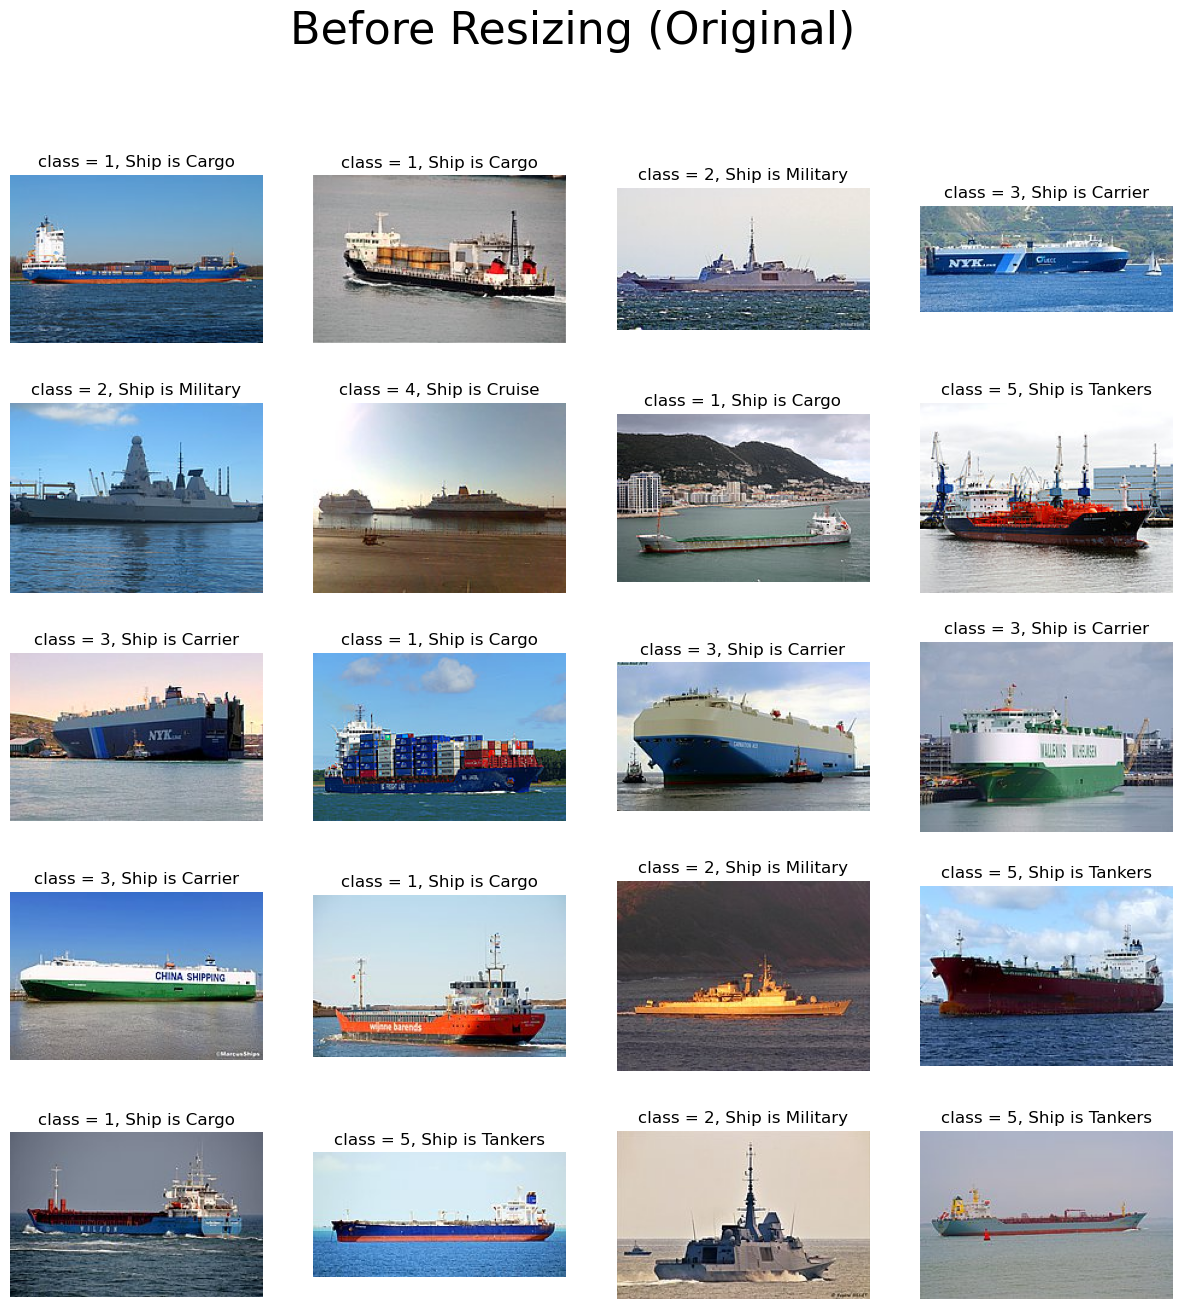

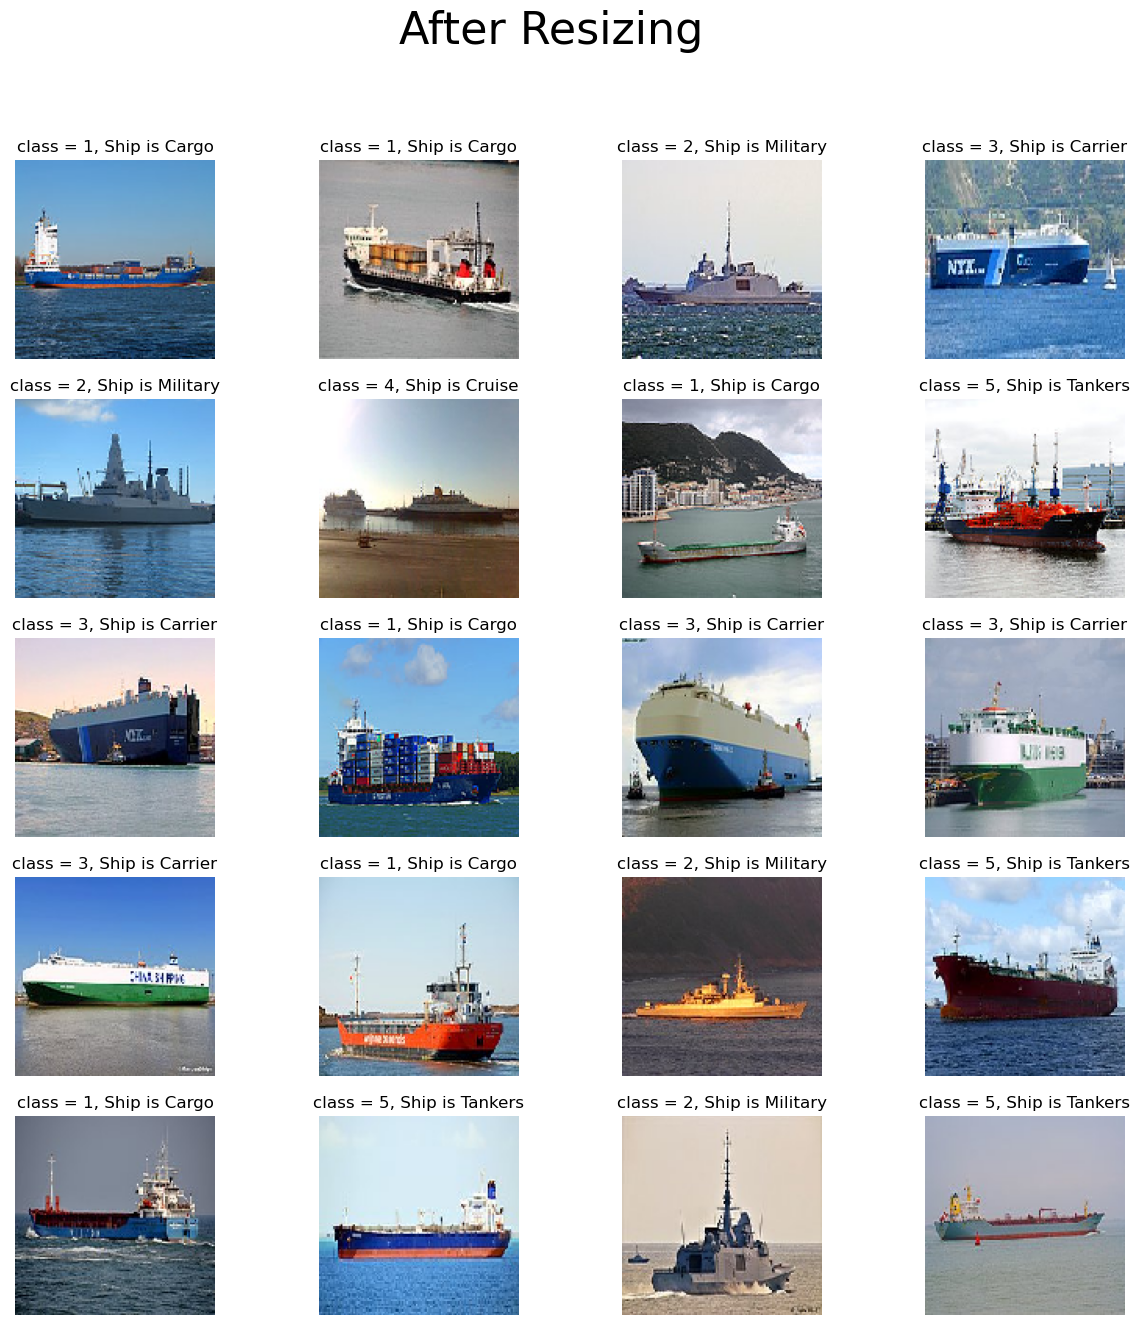

In [ ]:
nrow=5
ncol=4


fig1 = plt.figure(figsize=(15,15))
plt.suptitle('Before Resizing (Original)',size=32)
print()
for i in range (0,20):
    plt.subplot(nrow,ncol,i+1)
    plt.imshow(plt.imread(all_paths[i]))
    plt.title('class = {x}, Ship is {y}'.format(x=train_df["category"][i],y=dictclass[train_df["category"][i]]))
    plt.axis('Off')
    plt.grid(False)


fig2 = plt.figure(figsize=(15,15))
fig2.suptitle('After Resizing',size=32)
for i in range (0,20):
    plt.subplot(nrow,ncol,i+1)
    plt.imshow(resized_image_list[i])
    plt.title('class = {x}, Ship is {y}'.format(x=train_df["category"][i],y=dictclass[train_df["category"][i]]))
    plt.axis('Off')
    plt.grid(False)


Before we move on to make a neural network, I would like to add that resizing the images is not the only way to feed input to the CNN. In fact, there are better ways like making an FCN(Fully Convolutional Neural Network) that can take variable size inputs. In the near future, I would update this notebook to make a FCN, so remain posted :)

# Data Augmentation

It is necessary for the neural network to be exposed to different variations of images, to improve accuracy and reduce overfitting. Here we will use the data RandomFlip and RandomRotation method to augment data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Here the random flip method flips the image according to the parameter given, and the rotation method rotates the image.

Now let's start with making our model. Let's first make our class df and split the training data into train and test to measure the accuracy(One can also think of this as a cross-validation set).


# Building A Neural Network Model From Scratch

In [ ]:
class_values=train_df["category"]-1
class_values

0       0
1       0
2       1
3       2
4       1
       ..
6247    2
6248    1
6249    4
6250    2
6251    0
Name: category, Length: 6252, dtype: int64

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(resized_image_list, class_values, train_size=0.70,test_size=0.30, random_state=1)

In [ ]:
print(train_x.shape,train_y.shape)

(4376, 128, 128, 3) (4376,)


We have successfully split the training data into a 7:3 ratio. Now let's move on to the interesting part - **BUILDING A NEURAL NETWORK**

We are going to use the tensorflow library to build our model. As this neural network would be made from scratch, I do not expect to have a very great accuracy, but it is worth a try.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(128,128,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 16)       

Here I have given 3 convolution layers, with a maxpooling layer between each convolution layer. The padding attribute adds padding to each convolved image ensuring that the output image has same dimensions as the input.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 16)       

The convolved images are then flattened into a 1-D array and are passed into the neural network with two layers. The output layer is of 5 nodes as we have 5 classes.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

We the compile it using the loss function and an optimizer that helps the neural network to converge. We test it on its accuracy to determine how well has our neural network performed.

In [ ]:
model.fit(train_x, train_y, epochs=50, batch_size=128, shuffle=True)

Epoch 1/50
35/35 [==============================] - 15s 75ms/step - loss: 1.5175 - accuracy: 0.3432
Epoch 2/50
35/35 [==============================] - 2s 67ms/step - loss: 1.3233 - accuracy: 0.4429
Epoch 3/50
35/35 [==============================] - 2s 67ms/step - loss: 1.2093 - accuracy: 0.4941
Epoch 4/50
35/35 [==============================] - 2s 66ms/step - loss: 1.1487 - accuracy: 0.5201
Epoch 5/50
35/35 [==============================] - 2s 67ms/step - loss: 1.1021 - accuracy: 0.5386
Epoch 6/50
35/35 [==============================] - 2s 67ms/step - loss: 1.0803 - accuracy: 0.5441
Epoch 7/50
35/35 [==============================] - 2s 67ms/step - loss: 1.0433 - accuracy: 0.5610
Epoch 8/50
35/35 [==============================] - 2s 66ms/step - loss: 0.9886 - accuracy: 0.5839
Epoch 9/50
35/35 [==============================] - 2s 67ms/step - loss: 0.9624 - accuracy: 0.5992
Epoch 10/50
35/35 [==============================] - 2s 69ms/step - loss: 0.9409 - accuracy: 0.6122
Epoch 11

Our neural network has been trained. Let's test the accuracy of our NN on the cross-validation set.

In [ ]:
model.evaluate(test_x,test_y)

59/59 [==============================] - 1s 11ms/step - loss: 0.6959 - accuracy: 0.7393


[0.6958878636360168, 0.7393389940261841]

As expected, the accuracy of our model is not so great. I tried to tune the neural networks as best as I could and we have reached an accuracy of 69%. But let's not get demotivated, and use a very famous concept in Neural Networks called Transfer Learning

# Transfer Learning

Transfer Learning is a very important and widely used technique in the world of Machine Learning. It has a very simple and basic concept - Taking information(in the case of NN, weights are the information) learned from a task and aplying it on a task in-hand. In other words, we take the weights of a neural network that has been trained on some other dataset and apply the weights to our neural network and voila, we have a neural network with amazing accuracy in our hands, It is an amazing technique that brings all the machine learning practioners like us together.

For our transfer learning model, we will be using the weights of the Google Inception V3 Neural Network. There are many choices, and any of them can be chosen, but I chose this due to its better results and robustness.

In [ ]:
transfer_model=InceptionV3(input_shape=(128,128,3),include_top=False,weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


Here the include_top attribute is set to False to avoid the classification layers. We will later add our own classification layer. The weights are taken from the imagenet tarined neural network.

In [ ]:
transfer_model.trainable=False

This does not allow the weights to change or to re-train. After all we need the original weights from Incption for better accuracy.

In [ ]:
transfer_model.output


<KerasTensor: shape=(None, 2, 2, 2048) dtype=float32 (created by layer 'mixed10')>

In [ ]:
transfer_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                                                                                       

In [ ]:
transfer_final_layer = transfer_model.get_layer('mixed4')

Inception basically consists of many layers and each group of layers has a name like mixed0, mixed5 etc till mixed10. You can the train the neural network on the entire Inception NN or can choose a subset of layers by testing them out. I had the best accuracy till the mixed4 layer so I would be continuing with this.

Now, we can add our own dense layers before we add the classification layer or directly add the classification layer, whichever gives a better result. I have directly added a classification layer and hence used it to predict.

In [ ]:
x = data_augmentation(transfer_final_layer.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

In [ ]:
transfer_model.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_2')>

In [ ]:
transfer_model = tf.keras.Model(transfer_model.input, x)

In [ ]:
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                                                                                              

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
transfer_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics = ['accuracy'],
             loss='sparse_categorical_crossentropy')

Here the callback function refers to the function that would stop the training of the neural network if the loss function does not reduce after a certain specified number of epochs. That specified number is known as the patience.

In [ ]:
transfer_model.fit(train_x, train_y,validation_steps=50, verbose=1, epochs=50, callbacks=[callback])

Epoch 1/50
137/137 [==============================] - 7s 22ms/step - loss: 1.0783 - accuracy: 0.5731
Epoch 2/50
137/137 [==============================] - 2s 17ms/step - loss: 0.6632 - accuracy: 0.7610
Epoch 3/50
137/137 [==============================] - 2s 17ms/step - loss: 0.5515 - accuracy: 0.8046
Epoch 4/50
137/137 [==============================] - 2s 18ms/step - loss: 0.4735 - accuracy: 0.8398
Epoch 5/50
137/137 [==============================] - 2s 18ms/step - loss: 0.4296 - accuracy: 0.8505
Epoch 6/50
137/137 [==============================] - 2s 18ms/step - loss: 0.4050 - accuracy: 0.8592
Epoch 7/50
137/137 [==============================] - 2s 18ms/step - loss: 0.3620 - accuracy: 0.8787
Epoch 8/50
137/137 [==============================] - 2s 18ms/step - loss: 0.3473 - accuracy: 0.8800
Epoch 9/50
137/137 [==============================] - 3s 19ms/step - loss: 0.3287 - accuracy: 0.8889
Epoch 10/50
137/137 [==============================] - 3s 19ms/step - loss: 0.3199 - accura

In [ ]:
transfer_model.evaluate(test_x,test_y)

59/59 [==============================] - 2s 28ms/step - loss: 0.3936 - accuracy: 0.8609


[0.3936244547367096, 0.8608741760253906]

Wow, the accuracy has certainly improved from 69% to nearly 87% for the cross-validation data. That is a big boost and a satisfactory result. Now let's test it on our test data

# Test Data Prediction

In [ ]:
test_df = pd.read_csv("/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv")
test_df.head()

image
0  1007700.jpg
1  1011369.jpg
2  1051155.jpg
3  1062001.jpg
4  1069397.jpg

Before we predict, we must first preprocess the data to resize the images.

In [ ]:
path="/kaggle/input/game-of-deep-learning-ship-datasets/train/images"
resized_test_images=[]
refactor_size=128
for i in range(test_df.shape[0]):
    image_path=os.path.join(path,test_df["image"][i])
    img=tf.keras.utils.load_img(image_path,target_size=(refactor_size,refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)
    resized_test_images.append(imgarr)
resized_test_images = np.asarray(resized_test_images)

Let's see few of our test images to get an idea of what we are about to preidct -

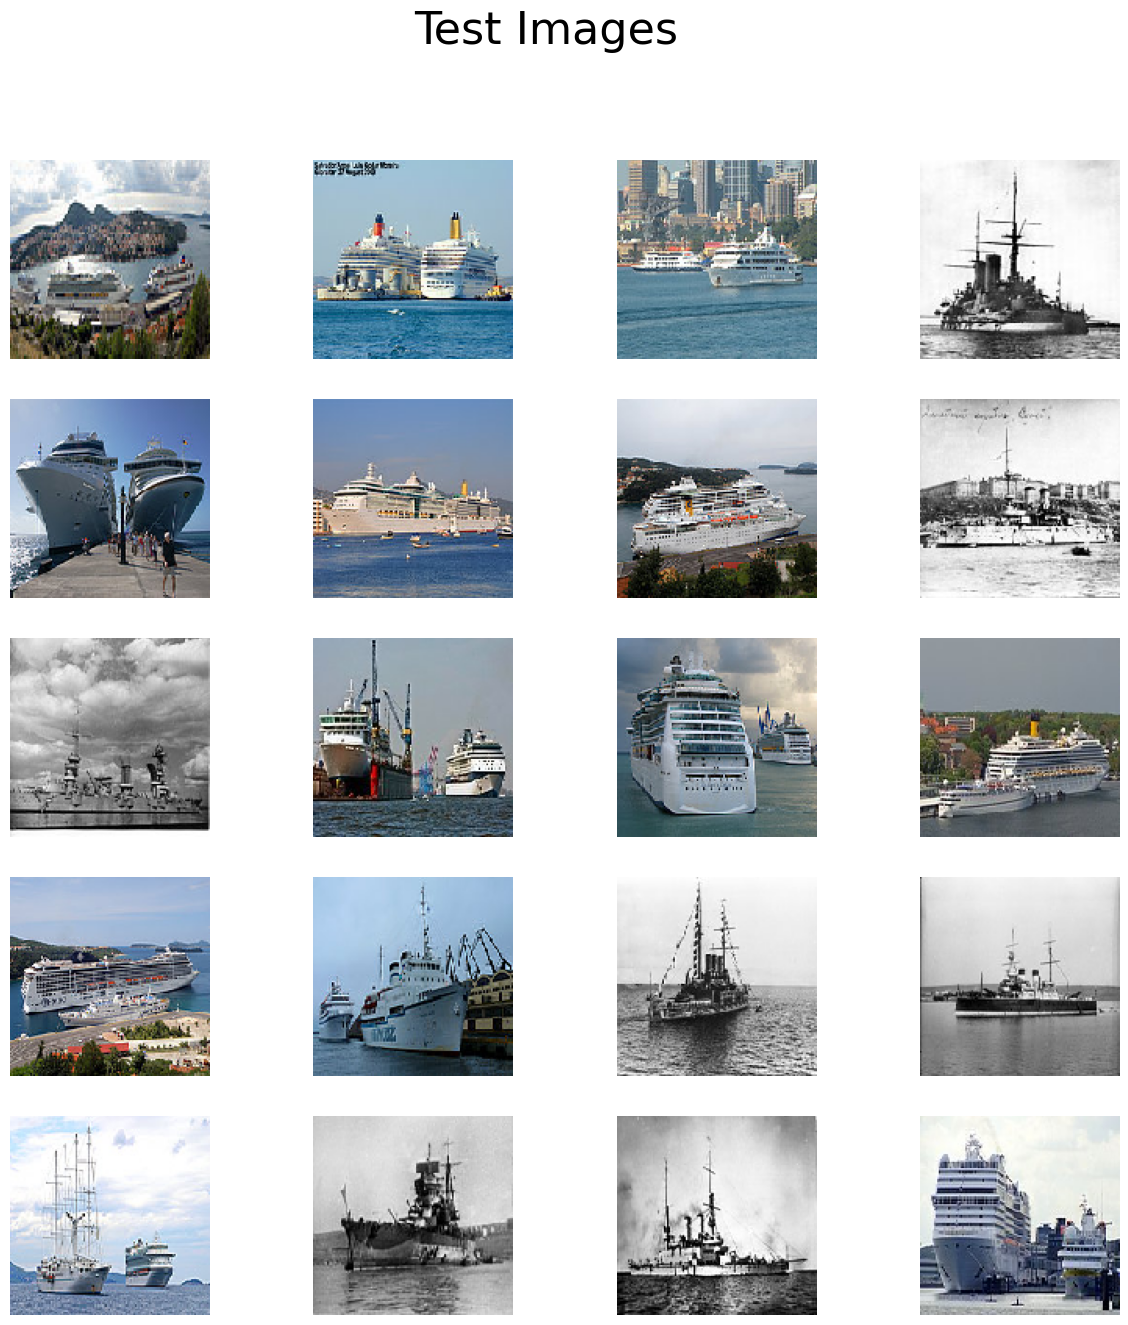

In [ ]:
fig2 = plt.figure(figsize=(15,15))
fig2.suptitle('Test Images',size=32)
for i in range (0,20):
    plt.subplot(5,4,i+1)
    plt.imshow(resized_test_images[i])
    plt.axis('Off')
    plt.grid(False)

In [ ]:
resized_test_images.shape

(2680, 128, 128, 3)

Let's predict and hope for the best -

In [ ]:
pred=transfer_model.predict(resized_test_images)

84/84 [==============================] - 2s 15ms/step


Now we must make an output submission file with all our predictions -

In [ ]:

sub = pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/sample_submission_ns2btKE.csv')
sub['category'] = np.argmax(pred, axis=1) + 1

In [ ]:
sub.head(20)

image  category
0   1007700.jpg         4
1   1011369.jpg         4
2   1051155.jpg         4
3   1062001.jpg         2
4   1069397.jpg         4
5   1072861.jpg         4
6   1097264.jpg         4
7   1098763.jpg         2
8   1098766.jpg         4
9   1101145.jpg         1
10  1114371.jpg         4
11  1114781.jpg         4
12  1115492.jpg         4
13  1121306.jpg         2
14  1123736.jpg         2
15  1124946.jpg         2
16  1125700.jpg         1
17  1127236.jpg         2
18  1127336.jpg         2
19  1130300.jpg         4

As we can see, the first image has been predicted as a cruise ship, and if we look at the test images visualization above, the first image does look like a cruise ship. Similarily others can be cross-checked too. It looks like our neural network is on point with its predictions.



In [ ]:
sub.to_csv('submission.csv', index=False)

# Missclassification

We can improve our model or at the very least find the inaccuracies made by our model by getting hold of the missclassified images.

In [ ]:
pred = transfer_model.predict(test_x)

59/59 [==============================] - 1s 15ms/step


In [ ]:
pred_label = np.argmax(pred,axis=1)
actual_label = test_y
pred_label

array([4, 1, 0, ..., 0, 1, 2])

Text(50.722222222222214, 0.5, 'Actual')

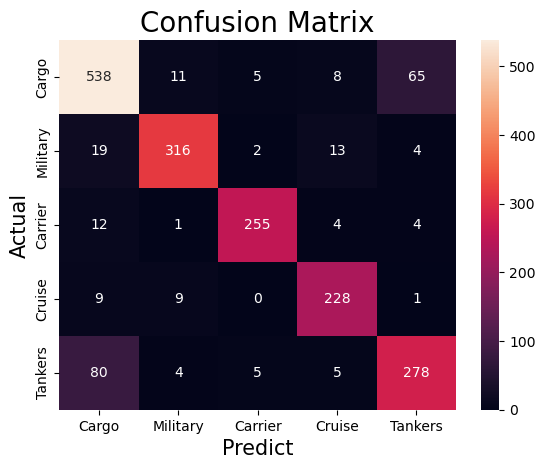

In [ ]:
labels = ["Cargo","Military","Carrier","Cruise","Tankers"]
sns.heatmap(confusion_matrix(actual_label,pred_label),annot=True,fmt='g',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize = 20)
plt.xlabel('Predict', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)

As we can see from the confusion matrix, it looks like that the neural network is having trouble in differentiating between the cargo and tanker images. It is understandable as many tankers do look like they are carrying cargo.

# ENDING NOTES

This is the end of this notebook. I will be making changes and making the convolutional neural network better. The missclassification has also given insights that more images of tankers are required to differentiate between the cargo ships and the tanker ship. If you have any methods or techniques that would reduce this missclassification, do let me know in the comments of this notebook, any help would be deeply appreciated. A fully connected convolutional neural network is also in the making, so stay tuned people. Cheers!